# QC script to calculate sharpness metric for images in a plate

The following script will access the IDR images in
a facility manager's context.
The QC script does the following:
1. Extracts Images from IDR (read-only)
2. Calculates sharpness based on the algorithm defined
in the following publication
  * [Image Sharpness Measure for Blurred Images in Frequency Domain](https://doi.org/10.1016/j.proeng.2013.09.086)
3. Creates a numpy array of the sharpness scores for every well,
  * separately for every field and every channel
  * the numpy array is then reshaped to the same dimensions of the plate
   e.g. 96 well plates will create an array with 8 rows and 12 columns.
4. Plots a heatmap for every field and every channel, and arranges all plots within a subplot.

# Workflow summary

![Overview](./includes/PlateToHeatmap.jpg)

***Import Packages***

In [1]:
from past.utils import old_div
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from scipy import ndimage
from scipy.ndimage import convolve
from scipy import misc
from IPython.display import HTML
from idr import connection

## Read data from IDR (Public Database : Read-only!)

### Create connection and plate identifier

In [2]:
conn = connection()
plateId = 408

Connected to IDR ...


### Fetch plate object and print details

In [3]:
plate = conn.getObject("Plate", plateId)
print("\nNumber of fields:", plate.getNumberOfFields())
print("\nGrid size:", plate.getGridSize())
print("\nWells in Plate:", plate.getName())

plate_rows = plate.getRows()
plate_columns = plate.getColumns()
plate_format = plate_rows * plate_columns

print("\nPlate Format:", plate_format)


Number of fields: (0L, 0L)

Grid size: {'rows': 16L, 'columns': 24L}

Wells in Plate: 0001-03--2005-08-01

Plate Format: 384


***Algorithm List***

In [4]:
class AlgorithmList:
    def fourierBasedSharpnessMetric(self):
        fftimage = np.fft.fft2(plane)
        fftshift = np.fft.fftshift(fftimage)
        fftshift = np.absolute(fftshift)
        M = np.amax(fftshift)
        Th = (fftshift > (old_div(M, float(1000)))).sum()
        if 'image' in locals():
            size = float(image.getSizeX()*image.getSizeY())
            sharpness = old_div(Th, size)
            return sharpness*10000
        else:
            return Th

    def gradientBasedSharpnessMetric(self):
        gy, gx = np.gradient(plane)
        gnorm = np.sqrt(gx**2 + gy**2)
        sharpness = np.average(gnorm)
        return sharpness

    def edgeBasedSharpnessMetric(self):
        edges1 = feature.canny(plane, sigma=3)
        kernel = np.ones((3, 3))
        kernel[1, 1] = 0
        sharpness = convolve(edges1, kernel, mode="constant")
        sharpness = sharpness[edges1 != 0].sum()
        return sharpness


print("loaded:", dir(AlgorithmList))

loaded: ['__doc__', '__module__', 'edgeBasedSharpnessMetric', 'fourierBasedSharpnessMetric', 'gradientBasedSharpnessMetric']


### Test your algorithm on example data

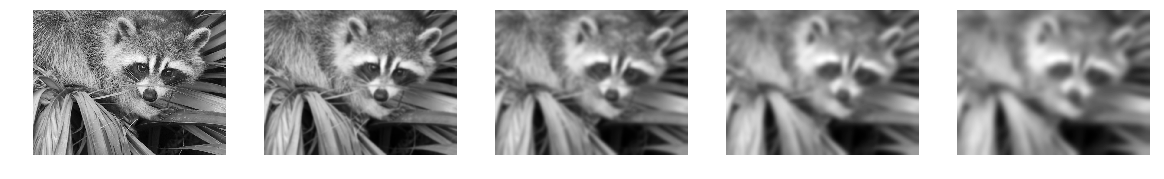

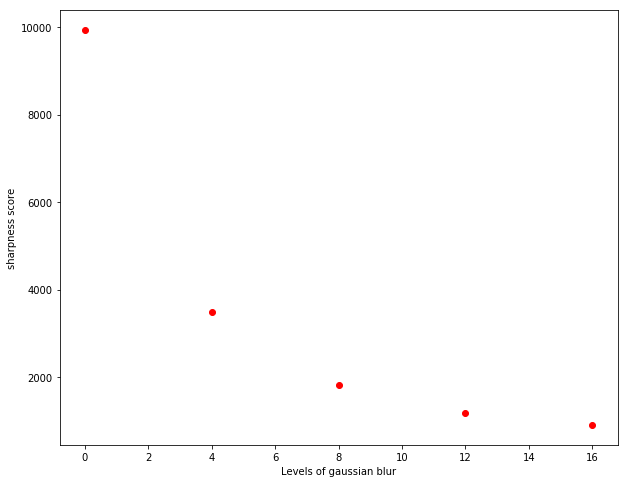

[[0.000e+00 9.941e+03]
 [4.000e+00 3.495e+03]
 [8.000e+00 1.805e+03]
 [1.200e+01 1.179e+03]
 [1.600e+01 9.010e+02]]


<Figure size 432x288 with 0 Axes>

In [5]:
resultArray = np.zeros((5, 2), dtype=float)
plt.figure(figsize=(20, 15))
cntr = 1
for sigValue in range(0, 20, 4):
    face = misc.face(gray=True)
    plane = ndimage.gaussian_filter(face, sigma=sigValue)
    plt.subplot(1, 5, cntr)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    sharpness = AlgorithmList().fourierBasedSharpnessMetric()
    resultArray[cntr - 1, 1] = sharpness
    resultArray[cntr - 1, 0] = sigValue
    cntr = cntr + 1

plt.show()
plt.figure(figsize=(10, 8))
plt.plot(resultArray[:, 0], resultArray[:, 1], 'ro')
plt.xlabel('Levels of gaussian blur')
plt.ylabel('sharpness score')
plt.show()

plt.gcf().clear()
print(resultArray)

### Test your algorithm on plate data

0001-03--2005-08-01 [Well 125, Field 1 (Spot 125)] 


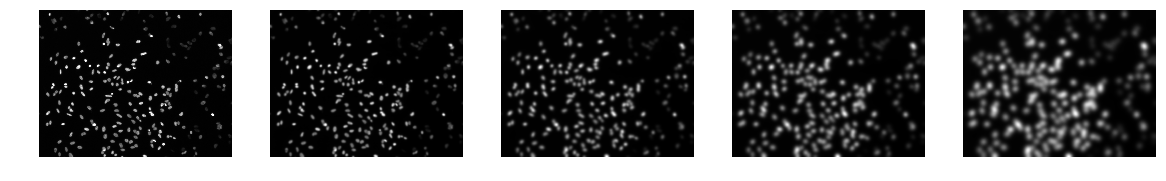

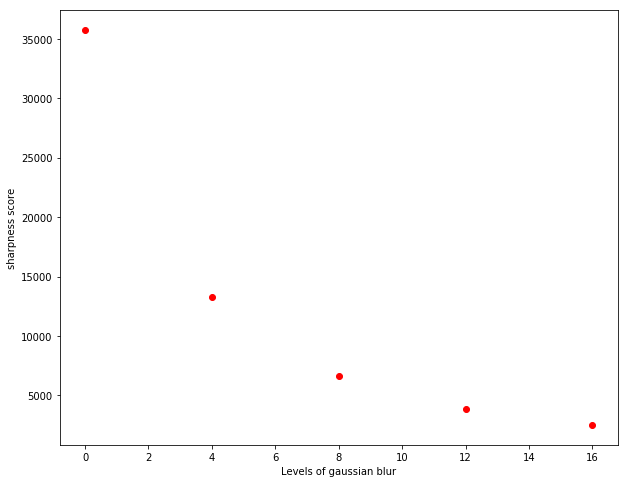

[[0.0000e+00 3.5775e+04]
 [4.0000e+00 1.3319e+04]
 [8.0000e+00 6.5890e+03]
 [1.2000e+01 3.8610e+03]
 [1.6000e+01 2.5030e+03]]


<Figure size 432x288 with 0 Axes>

In [6]:
imageId = 171499
image = conn.getObject("Image", imageId)
print(image.getName(), image.getDescription())

pixels = image.getPrimaryPixels()
image_plane = pixels.getPlane(0, 0, 0)

resultArray = np.zeros((5, 2), dtype=float)
plt.figure(figsize=(20, 15))
cntr = 1
for sigValue in range(0, 20, 4):
    face = misc.face(gray=True)
    plane = ndimage.gaussian_filter(image_plane, sigma=sigValue)
    plt.subplot(1, 5, cntr)
    plt.imshow(plane, cmap=plt.cm.gray)
    plt.axis('off')
    sharpness = AlgorithmList().fourierBasedSharpnessMetric()
    resultArray[cntr - 1, 1] = sharpness
    resultArray[cntr - 1, 0] = sigValue
    cntr = cntr + 1
plt.show()
plt.figure(figsize=(10, 8))
plt.plot(resultArray[:, 0], resultArray[:, 1], 'ro')
plt.xlabel('Levels of gaussian blur')
plt.ylabel('sharpness score')
plt.show()
plt.gcf().clear()
print(resultArray)

### Iterative calculations for the whole plate
`stride_r = 4` and `stride_c = 4` so that this notebook
can be run quickly as an example.
To check all 384 wells change them both to `1`.

In [7]:
stride_r = 4
stride_c = 4
chnames = None
cntr = 0
fields = 0
size_z = fields
print("Iterating through wells...")
rc = dict(((well.row, well.column), well) for well in plate.listChildren())
for wrc in sorted(rc.keys()):
    if wrc[0] % stride_r > 0 or wrc[1] % stride_c > 0:
        continue
    well = rc[wrc]
    print('Row:%d Column:%d' % (well.row, well.column))
    index = well.countWellSample()
    image = well.getImage(fields)
    if chnames is None:
        chnames = [ch.getLabel() for ch in image.getChannels(True)]
    pixels = image.getPrimaryPixels()
    size_c = image.getSizeC()
    if cntr == 0:
        result_array = np.full((plate_format, size_c), np.nan)
    for ch in range(0, size_c):
        plane = pixels.getPlane(0, ch, 0)
        sharpness = AlgorithmList().fourierBasedSharpnessMetric()
        wellid = well.row * plate_columns + well.column
        result_array[wellid, ch] = sharpness
        tempvalue = result_array[wellid, ch]
        fieldid = (fields + ch * size_c)
        cntr = cntr + 1

Iterating through wells...
Row:0 Column:0
Row:0 Column:4
Row:0 Column:8
Row:0 Column:12
Row:0 Column:16
Row:0 Column:20
Row:4 Column:0
Row:4 Column:4
Row:4 Column:8
Row:4 Column:12
Row:4 Column:16
Row:4 Column:20
Row:8 Column:0
Row:8 Column:4
Row:8 Column:8
Row:8 Column:12
Row:8 Column:16
Row:8 Column:20
Row:12 Column:0
Row:12 Column:4
Row:12 Column:8
Row:12 Column:12
Row:12 Column:16
Row:12 Column:20


### Reshape numpy array and plot heatmaps

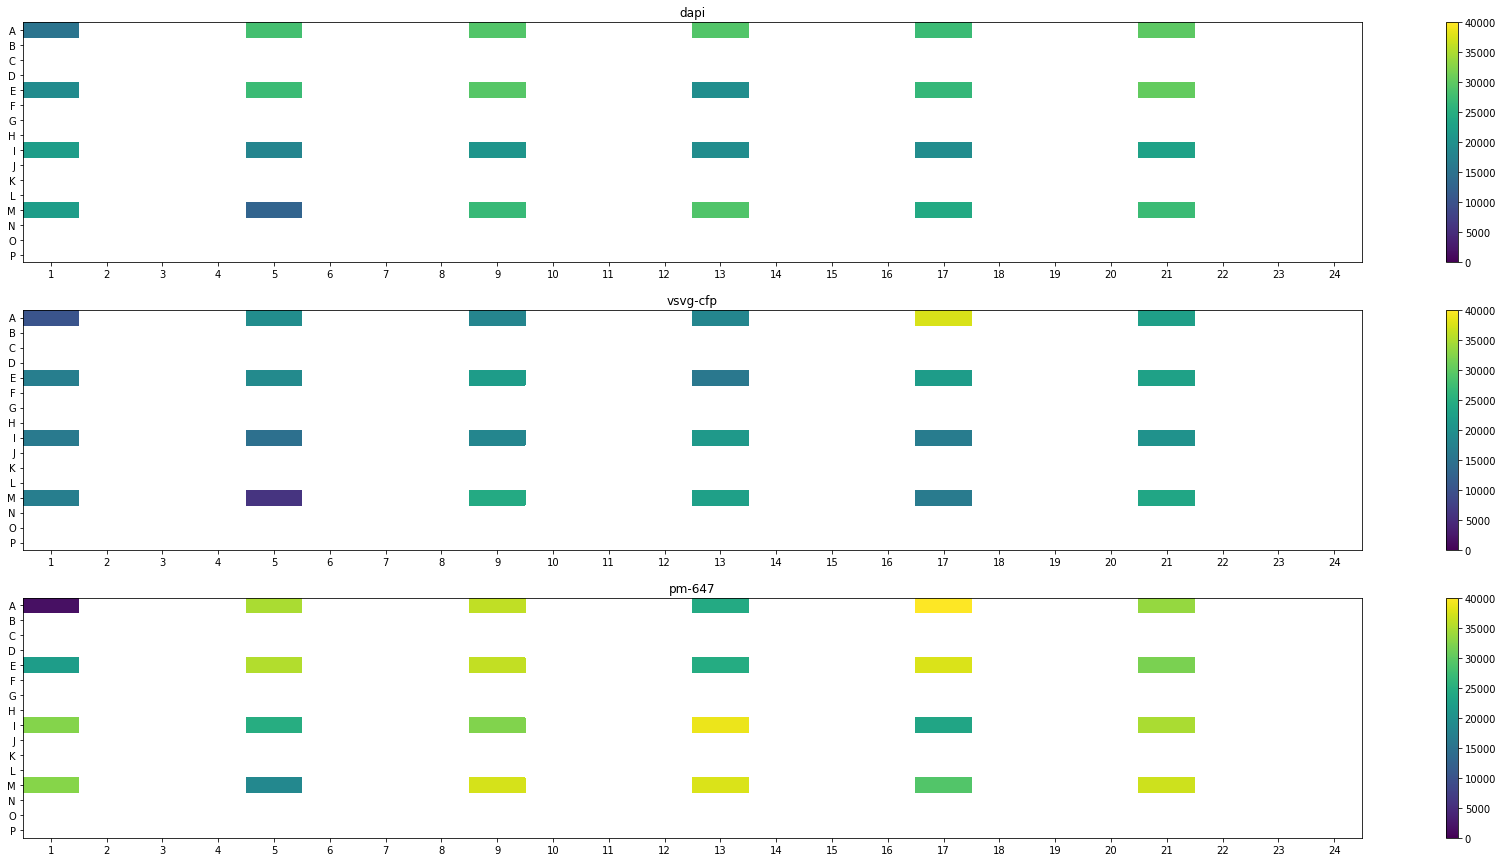

In [8]:
alphabets = list(string.ascii_uppercase)
plate_name = plate.getName()
colval = 0
planes = []
cntr = 0
size_c = 3
fig = plt.figure(figsize=(30, 15))
for rowval in range(0, size_c):
    data = result_array[:, rowval].reshape(plate_rows, plate_columns)
    ax = plt.subplot(size_c, 1, cntr + 1)
    plt.pcolor(data)
    plt.colorbar()
    ax.title.set_text(chnames[rowval])
    plt.xticks(np.arange(0.5, plate_columns, 1.0))
    plt.yticks(np.arange(0.5, plate_rows, 1.0))
    xlabels = range(1, plate_columns+1)
    ax.set_xticklabels(xlabels)
    ylabels = range(1, plate_rows+1)
    ax.set_yticklabels([alphabets[i - 1] for i in ylabels])
    plt.gca().invert_yaxis()
    plt.clim(0, 40000)

    data = np.repeat(data, 20, axis=1)
    data = np.repeat(data, 20, axis=0)
    planes.append(np.uint16(data))
    cntr = cntr + 1

plt.show()
fig.savefig(plate_name + 'SharpnessHeatMaps.png')

***Thumbnails of top2 and bottom 2 percentile images***

In [9]:
mapAnnotationNameSpace = "openmicroscopy.org/mapr/gene"
bulkAnnotationNameSpace = "openmicroscopy.org/omero/bulk_annotations"


def id_to_image_html(id):
    return '<img src="http://idr.openmicroscopy.org/webclient/render_thumbnail/%d/"/>' % id


def getGeneInformation(image):
    id = image.getId()
    image1 = conn.getObject('Image', id)
    cc = image1.getAnnotation(mapAnnotationNameSpace)
    rows = cc.getValue()
    html = []
    for r in rows:
        if r[1].startswith("http"):
            tempvar = "<a href='" + r[1] + "'>" + r[1] + "</a>"
        else:
            tempvar = r[1]
        html.append("<tr><td>" + tempvar + "</td></tr>")
    return ("<table>" + "".join(html) + "</table>")


def getQualityControl(image):
    id = image.getId()
    image1 = conn.getObject('Image', id)
    cc = image1.getAnnotation(bulkAnnotationNameSpace)
    rows = cc.getValue()
    html = []
    for r in rows:
        if r[0].startswith('Control') or r[0].startswith('Quality'):
            html.append("<tr><td>" + r[1] + "</td></tr>")
    return ("<table>" + "".join(html) + "</table>")


fields = 0
ch = 2

result_array_ch = result_array[:, ch]
threshold = np.percentile(result_array_ch[~np.isnan(result_array_ch)], 2)
imageList = []
for wrc in sorted(rc.keys()):
    if wrc[0] % stride_r > 0 or wrc[1] % stride_c > 0:
        continue
    well = rc[wrc]
    row = well.row
    column = well.column
    sharpness = result_array[((row)*plate_columns) + column, ch]
    if (sharpness <= threshold):
        image = well.getImage(fields)
        imageList.append(image)

images = [(x.id, x.id, x.getName(), x, x) for x in (imageList)]
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame(images, columns=['Id', 'Image', 'Name',
                                   'GeneInformation',
                                   'QualityControl'])
HTML(df.to_html(escape=False,
                formatters=dict(Image=id_to_image_html,
                                GeneInformation=getGeneInformation,
                                QualityControl=getQualityControl)))

In [10]:
mapAnnotationNameSpace = "openmicroscopy.org/mapr/gene"
bulkAnnotationNameSpace = "openmicroscopy.org/omero/bulk_annotations"


def id_to_image_html(id):
    return '<img src="http://idr.openmicroscopy.org/webclient/render_thumbnail/%d/"/>' % id


def getGeneInformation(image):
    id = image.getId()
    image1 = conn.getObject('Image', id)
    cc = image1.getAnnotation(mapAnnotationNameSpace)
    rows = cc.getValue()
    html = []
    for r in rows:
        if r[1].startswith("http"):
            tempvar = "<a href='" + r[1] + "'>" + r[1] + "</a>"
        else:
            tempvar = r[1]
        html.append("<tr><td>" + tempvar + "</td></tr>")
    return ("<table>" + "".join(html) + "</table>")


def getQualityControl(image):
    id = image.getId()
    image1 = conn.getObject('Image', id)
    cc = image1.getAnnotation(bulkAnnotationNameSpace)
    rows = cc.getValue()
    html = []
    for r in rows:
        if r[0].startswith('Control') or r[0].startswith('Quality'):
            html.append("<tr><td>" + r[1] + "</td></tr>")
    return ("<table>" + "".join(html) + "</table>")


fields = 0
ch = 2
result_array_ch = result_array[:, ch]
threshold = np.percentile(result_array_ch[~np.isnan(result_array_ch)], 98)
imageList = []
for well in plate.listChildren():
    row = well.row
    column = well.column
    sharpness = result_array[((row)*plate_columns) + column, ch]
    if (sharpness >= threshold):
        image = well.getImage(fields)
        imageList.append(image)

images = [(x.id, x.id, x.getName(), x, x) for x in (imageList)]
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame(images, columns=['Id', 'Image',
                                   'Name', 'GeneInformation',
                                   'QualityControl'])
HTML(df.to_html(escape=False,
                formatters=dict(Image=id_to_image_html,
                                GeneInformation=getGeneInformation,
                                QualityControl=getQualityControl)))

### Close Connection to IDR

In [11]:
conn.close()

### License
Copyright (C) 2016-2019 University of Dundee. All Rights Reserved.
This program is free software; you can redistribute it and/or modify it
under the terms of the GNU General Public License as published by the
Free Software Foundation; either version 2 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for
more details. You should have received a copy of the GNU General
Public License along with this program; if not, write to the
Free Software Foundation,
Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.